In [1]:
import plotly.express as px
import numpy as np
import nibabel as nib
from PIL import Image
import matplotlib.pyplot as plt
import os
import pandas as pd
import pickle

import sys
sys.path.append('../../modified_medsam_repo')
from MedSAM_HCP.dataset import MRIDataset, load_datasets
from MedSAM_HCP.MedSAM import MedSAM, medsam_inference
from MedSAM_HCP.build_sam import build_sam_vit_b_multiclass
from MedSAM_HCP.utils_hcp import *
from scipy import ndimage 


In [4]:
subcortical = ['Left-Caudate', 'Left-Putamen', 'Right-Caudate', 'Right-Putamen', 'Left-Pallidum', 'Right-Pallidum', 'Brain-Stem',
        'Left-Hippocampus', 'Left-Amygdala', 'Left-Accumbens-area', 'Left-VentralDC',
        'Right-Hippocampus', 'Right-Amygdala', 'Right-Accumbens-area', 'Right-VentralDC',
        'Left-Thalamus-Proper', 'Right-Thalamus-Proper']
wm = ['Left-Cerebral-White-Matter', 'Right-Cerebral-White-Matter', 
    'Left-Cerebellum-White-Matter', 'Right-Cerebellum-White-Matter', 'Optic-Chiasm',
    'CC_Anterior',
    'CC_Central',
    'CC_Mid_Anterior',
    'CC_Mid_Posterior',
    'CC_Posterior']

cortical = ['Left-Cerebellum-Cortex',
    'Right-Cerebellum-Cortex', 'ctx-lh-caudalanteriorcingulate', 'ctx-lh-caudalmiddlefrontal', 'ctx-lh-cuneus',
    'ctx-lh-entorhinal', 'ctx-lh-fusiform', 'ctx-lh-inferiorparietal', 'ctx-lh-inferiortemporal',
    'ctx-lh-isthmuscingulate', 'ctx-lh-lateraloccipital', 'ctx-lh-lateralorbitofrontal', 'ctx-lh-lingual',
    'ctx-lh-medialorbitofrontal', 'ctx-lh-middletemporal', 'ctx-lh-parahippocampal', 'ctx-lh-paracentral',
    'ctx-lh-parsopercularis', 'ctx-lh-parsorbitalis', 'ctx-lh-parstriangularis', 'ctx-lh-pericalcarine',
    'ctx-lh-postcentral', 'ctx-lh-posteriorcingulate', 'ctx-lh-precentral', 'ctx-lh-precuneus',
    'ctx-lh-rostralanteriorcingulate', 'ctx-lh-rostralmiddlefrontal', 'ctx-lh-superiorfrontal', 'ctx-lh-superiorparietal',
    'ctx-lh-superiortemporal', 'ctx-lh-supramarginal', 'ctx-lh-transversetemporal', 'ctx-lh-insula',
    'ctx-rh-caudalanteriorcingulate', 'ctx-rh-caudalmiddlefrontal', 'ctx-rh-cuneus', 'ctx-rh-entorhinal',
    'ctx-rh-fusiform', 'ctx-rh-inferiorparietal', 'ctx-rh-inferiortemporal', 'ctx-rh-isthmuscingulate',
    'ctx-rh-lateraloccipital', 'ctx-rh-lateralorbitofrontal', 'ctx-rh-lingual', 'ctx-rh-medialorbitofrontal',
    'ctx-rh-middletemporal', 'ctx-rh-parahippocampal', 'ctx-rh-paracentral', 'ctx-rh-parsopercularis',
    'ctx-rh-parsorbitalis', 'ctx-rh-parstriangularis', 'ctx-rh-pericalcarine', 'ctx-rh-postcentral',
    'ctx-rh-posteriorcingulate', 'ctx-rh-precentral', 'ctx-rh-precuneus', 'ctx-rh-rostralanteriorcingulate',
    'ctx-rh-rostralmiddlefrontal', 'ctx-rh-superiorfrontal', 'ctx-rh-superiorparietal', 'ctx-rh-superiortemporal',
    'ctx-rh-supramarginal', 'ctx-rh-transversetemporal', 'ctx-rh-insula'
]

ventricular_or_vessel = [
    '3rd-Ventricle',
    '4th-Ventricle',
    'CSF',
    'Left-Inf-Lat-Vent',
    'Left-Lateral-Ventricle',
    'Left-vessel',
    'Right-Inf-Lat-Vent',
    'Right-Lateral-Ventricle',
    'Right-vessel',
    'Left-choroid-plexus', 'Right-choroid-plexus'
]

groups = [wm, cortical, subcortical, ventricular_or_vessel]

In [20]:
def generate_color_map(seed = 2023):
    np.random.seed(2023)
    rand_nums = np.random.random((103, 3))
    color_label_mapper = dict()
    for i in range(103):
        color_label_mapper[i] = (rand_nums[i, :] * 255).astype('uint8')
    return color_label_mapper

def construct_rev_dict(label_converter):
    mapo = {}
    for i in range(103):
        xd = str(label_converter.compressed_to_name(i))
        mapo[xd] = i
    return mapo

def plot_for_slice(mri_raw_file_path, seg_slice, name_to_compressed_dict, group_list, slice_num, figure = None):
    assert seg_slice.shape == (103,256,256)
    img = nib.load(mri_raw_file_path).get_fdata().astype(np.uint8)[:, slice_num, :]
    img = np.repeat(img[:,:,None], 3, axis=-1)
    img = img / 255.

    n = 1
    m = len(group_list)
    if figure is None:
        fig, axs = plt.subplots(n, m, squeeze=False)
    else:
        axs = figure.subplots(n, m, squeeze=False)
        fig = figure
    ptr = 0
    listo_collect = []
    for grp in group_list:
        r = ptr // m
        c = ptr % m
        this_mask = np.zeros((256,256)) # initially all 0s
        for gg in grp:
            label_idx = name_to_compressed_dict[gg]
            this_mask = np.maximum(this_mask, seg_slice[label_idx, :, :])
            #this_mask = np.maximum(this_mask, seg_slice == name_to_compressed_dict[gg])
        
        listo_collect.append(this_mask)
        # add boundary weight
        # inner_mask = ndimage.binary_erosion(this_mask)
        # boundary_mask = np.bitwise_and(this_mask, np.invert(inner_mask))

        #this_mask = 1 - this_mask
        this_mask_img = np.repeat(this_mask[:,:,None], 3, axis=-1)
        blended = .4 * img + .6 * this_mask_img
        # rotate
        blended = np.rot90(blended)
        
        axs[r,c].imshow(blended, cmap='Greys')
        #axs[r,c].imshow((img * 255).astype(int))
        #axs[r,c].imshow(this_mask_img.astype(int) * 255, cmap = 'Greys', alpha = 0.6, vmin = 0, vmax = 1)
        axs[r,c].get_xaxis().set_ticks([])
        axs[r,c].get_yaxis().set_ticks([])
        ptr+=1
    #fig.subplots_adjust(wspace=0, hspace=0)

    return fig, np.stack(listo_collect,axis=0) # now will be 3,256,256

def generate_plots(mri_id, seg_path, group_list, slices = [], pass_single_slice = False, apply_hcp_to_compressed = False):

    train_test_splits_path = '/gpfs/data/luilab/karthik/pediatric_seg_proj/train_val_test_split.pickle'

    mri_raw_file_path = f'/gpfs/data/cbi/hcp/hcp_seg/data_orig/{mri_id}/mri/T1.mgz'
    seg_arr = np.load(seg_path)


    df_hcp = pd.read_csv('/gpfs/home/kn2347/HCP_MedSAM_project/modified_medsam_repo/hcp_mapping_processed.csv')
    df_desired = pd.read_csv('/gpfs/home/kn2347/HCP_MedSAM_project/modified_medsam_repo/darts_name_class_mapping_processed.csv')
    NUM_CLASSES = len(df_desired)
    label_converter = LabelConverter(df_hcp, df_desired)


    if pass_single_slice:
        if seg_arr.shape == (256,256):
            if apply_hcp_to_compressed:
                seg_arr = np.vectorize(label_converter.hcp_to_compressed)(seg_arr)
            # convert class indices to one-hot
            out = np.zeros((103, 256, 256))
            for i in range(256):
                for j in range(256):
                    lab = seg_arr[i,j]
                    out[lab, i, j] = 1
            seg_arr = out
        
        assert seg_arr.shape == (103, 256,256)
    else:
        assert seg_arr.shape == (256, 103, 256, 256)

    

    

    mapo = construct_rev_dict(label_converter)

    total_fig = plt.figure(constrained_layout=True, figsize = (4, 1.5 * len(slices)), dpi=300)
    subfigs = total_fig.subfigures(len(slices), 1, hspace=0, squeeze=False)

    concat_list = []
    for idx, slice_num in enumerate(slices):
        if pass_single_slice:
            seg_slice = seg_arr
        else:
            seg_slice = seg_arr[slice_num,:,:,:]
        _, stackarr = plot_for_slice(mri_raw_file_path = mri_raw_file_path, seg_slice = seg_slice, name_to_compressed_dict = mapo, group_list = group_list, slice_num = slice_num, figure = subfigs[idx,0])
        concat_list.append(stackarr)
    all_segs = np.stack(concat_list,axis=0)
    return total_fig, all_segs

In [18]:
zyz = np.load('/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/hcp_test_segmentations_12-30-24/segmentations/singletask_unprompted/162935/singletask_seg_all.npy')
print(np.sum(zyz, axis=1)[140,:,:].max())

3


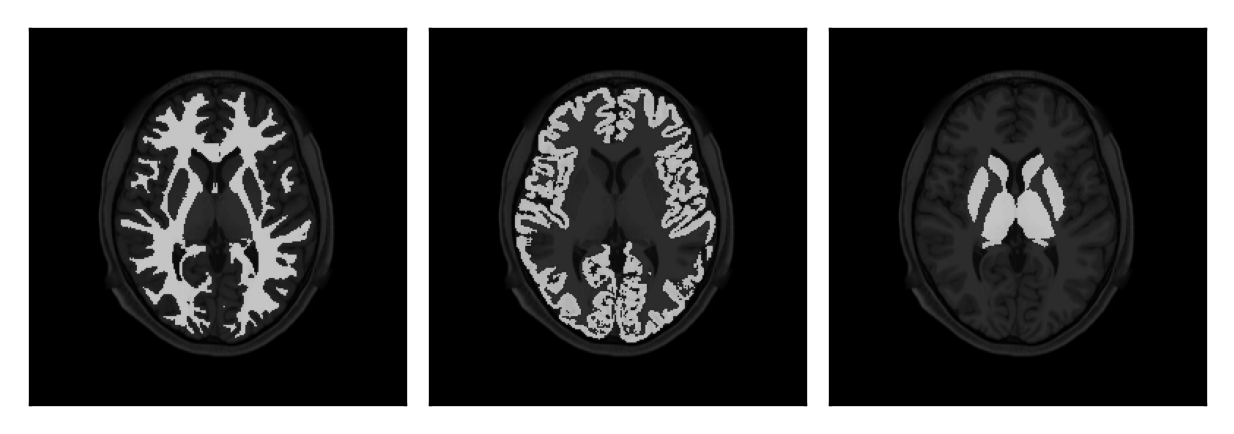

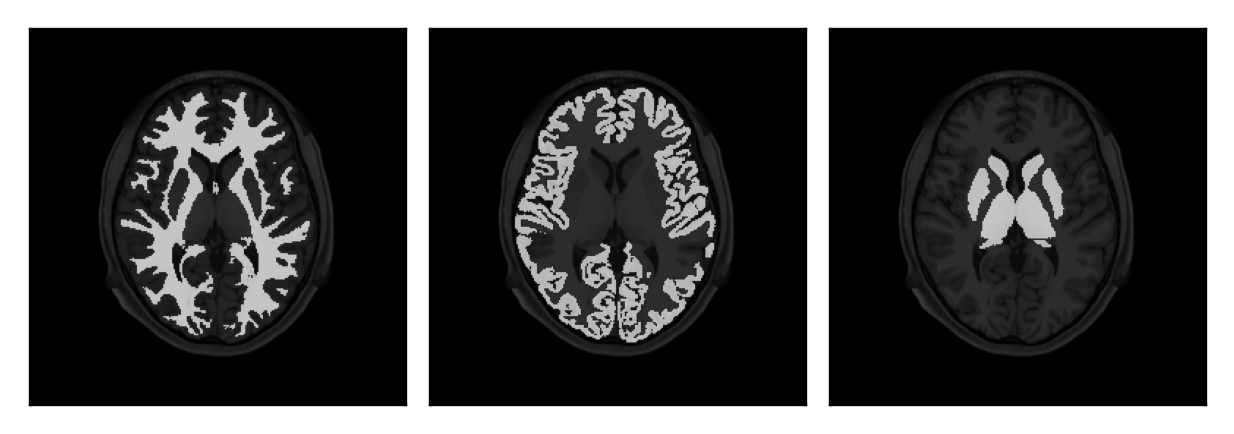

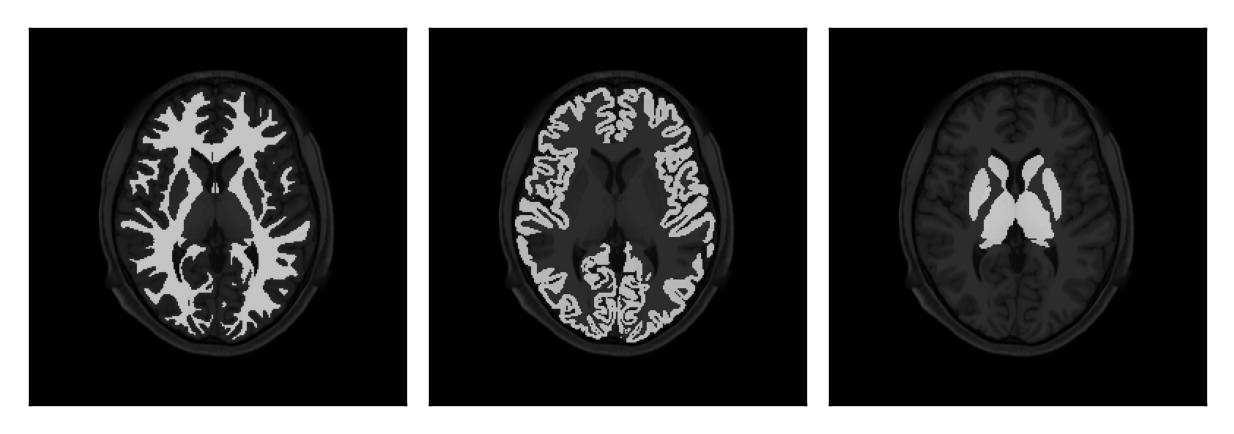

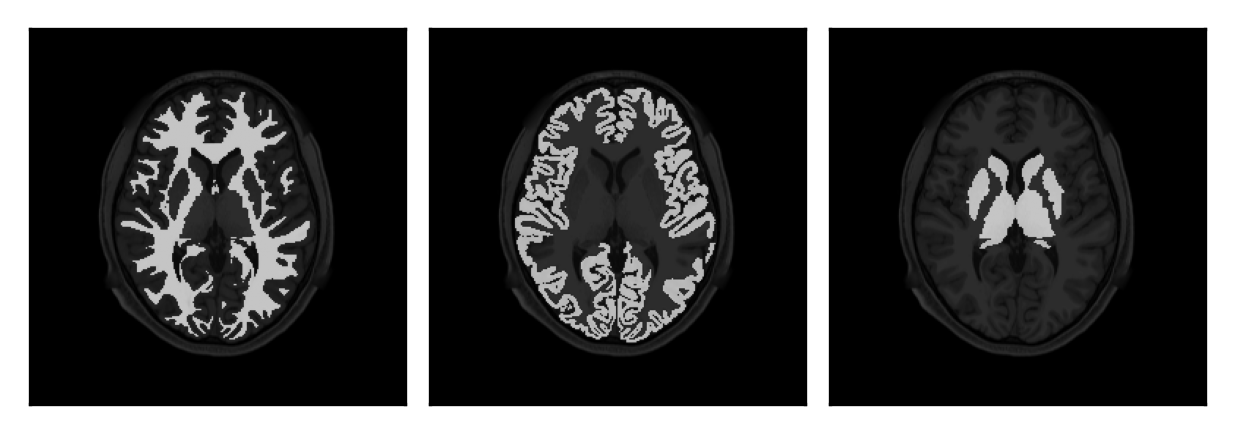

In [ ]:
mri_id = 162935
seg_path_medsam = '/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/hcp_test_segmentations_12-30-24/segmentations/singletask_unprompted/162935/singletask_seg_all.npy'
#slices = np.linspace(80, 220, 20, dtype=int)
slices = [140]
fig_medsam, medsam_seg = generate_plots(mri_id, seg_path_medsam, groups[:3], slices)

seg_path_medsam_oracle = '/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/hcp_test_segmentations_12-30-24/segmentations/singletask_oracle/162935/singletask_seg_all.npy'
fig_medsam_oracle, medsam_oracle_seg = generate_plots(mri_id, seg_path_medsam_oracle, groups[:3], slices)

seg_path_unet = '/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/hcp_test_segmentations_12-30-24/segmentations/singletask_unet/162935/singletask_seg_all.npy'
fig_unet, unet_seg = generate_plots(mri_id, seg_path_unet, groups[:3], slices)

seg_path_groundtruth = f'/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/segmentation_slices/162935/seg_{slices[0]}.npy'
fig_gt, gt_seg = generate_plots(mri_id, seg_path_groundtruth, groups[:3], slices, pass_single_slice = True, apply_hcp_to_compressed = True)

fig_medsam.savefig('/gpfs/home/kn2347/figs/hcp_test_set_162935_segmentations/medsam_seg.pdf', dpi=300)
fig_medsam_oracle.savefig('/gpfs/home/kn2347/figs/hcp_test_set_162935_segmentations/medsam_oracle_seg.pdf', dpi=300)
fig_unet.savefig('/gpfs/home/kn2347/figs/hcp_test_set_162935_segmentations/unet_seg.pdf', dpi=300)
fig_gt.savefig('/gpfs/home/kn2347/figs/hcp_test_set_162935_segmentations/groundtruth_seg.pdf', dpi=300)

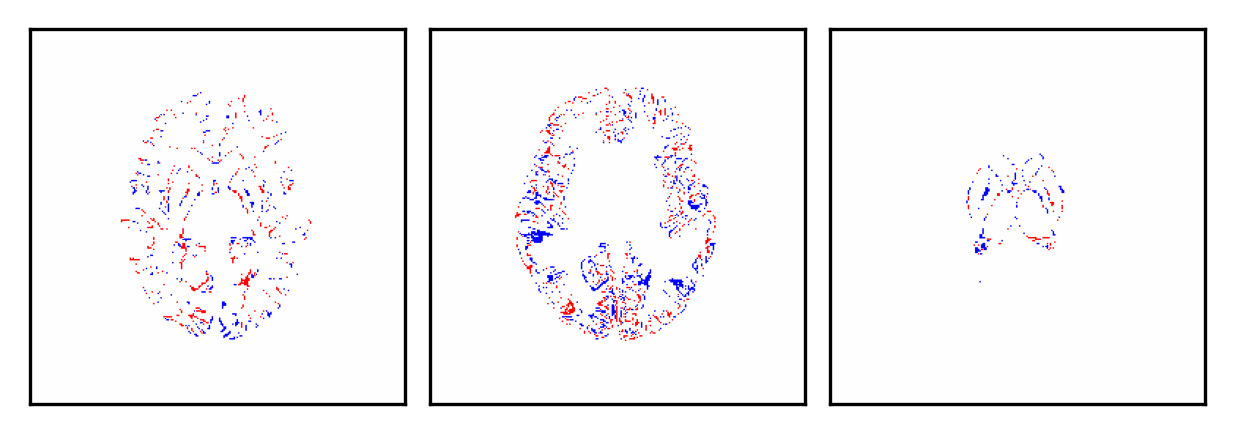

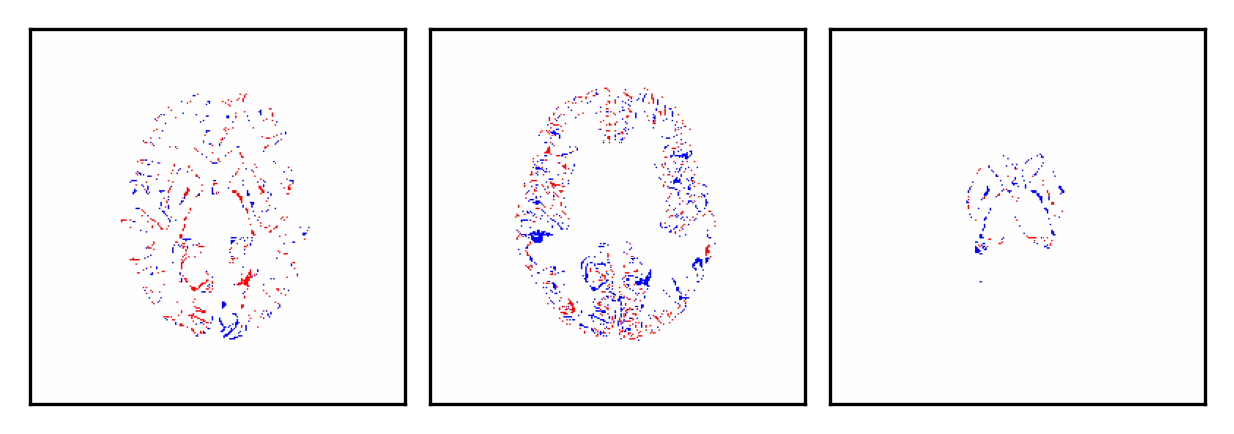

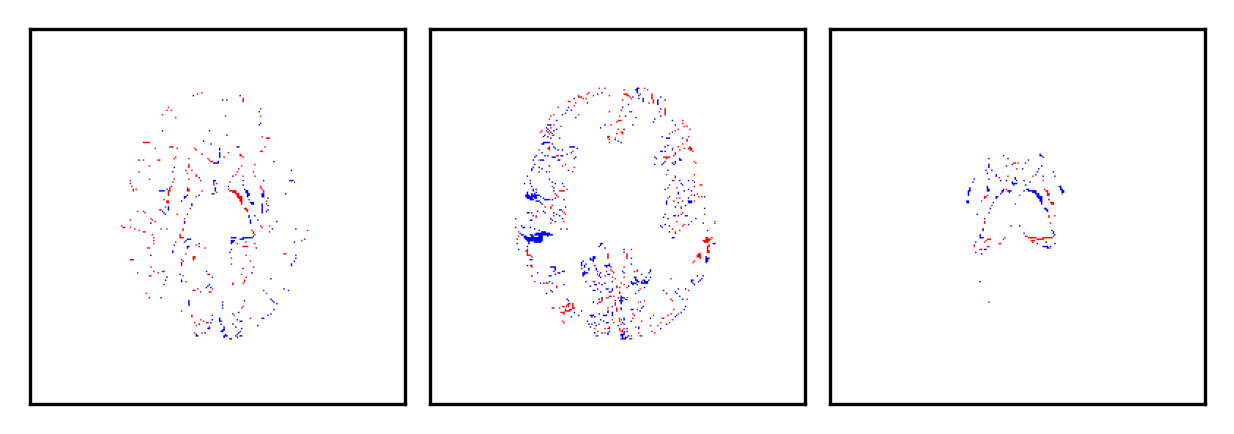

In [21]:
# create difference maps

for idx, slice_num in enumerate(slices):
    fig, axs = plt.subplots(1, 3, squeeze=False, figsize = (4, 1.5), dpi=300, constrained_layout = True)
    for pl in range(3):
        diff_map = (gt_seg.astype(int) - medsam_seg.astype(int))[idx,pl,:,:] 
        diff_map = np.sign(diff_map[:,:])
        diff_map = np.rot90(diff_map)
        axs[0,pl].imshow(diff_map, cmap='bwr_r', vmin=-1, vmax=1)
        axs[0,pl].set_xticks([])
        axs[0,pl].set_yticks([])
    fig.savefig('/gpfs/home/kn2347/figs/hcp_test_set_162935_segmentations/gt-medsam.pdf', dpi=300)

for idx, slice_num in enumerate(slices):
    fig, axs = plt.subplots(1, 3, squeeze=False, figsize = (4, 1.5), dpi=300, constrained_layout = True)
    for pl in range(3):
        diff_map = (gt_seg.astype(int) - medsam_oracle_seg.astype(int))[idx,pl,:,:] 
        diff_map = np.sign(diff_map[:,:])
        diff_map = np.rot90(diff_map)
        axs[0,pl].imshow(diff_map, cmap='bwr_r', vmin=-1, vmax=1)
        axs[0,pl].set_xticks([])
        axs[0,pl].set_yticks([])
    fig.savefig('/gpfs/home/kn2347/figs/hcp_test_set_162935_segmentations/gt-medsam_oracle.pdf', dpi=300)

for idx, slice_num in enumerate(slices):
    fig, axs = plt.subplots(1, 3, squeeze=False, figsize = (4, 1.5), dpi=300, constrained_layout = True)
    for pl in range(3):
        diff_map = (gt_seg.astype(int) - unet_seg.astype(int))[idx,pl,:,:] 
        diff_map = np.sign(diff_map[:,:])
        diff_map = np.rot90(diff_map)
        axs[0,pl].imshow(diff_map, cmap='bwr_r', vmin=-1, vmax=1)
        axs[0,pl].set_xticks([])
        axs[0,pl].set_yticks([])
    fig.savefig('/gpfs/home/kn2347/figs/hcp_test_set_162935_segmentations/gt-unet.pdf', dpi=300)